### Import needed libraries
### Get the stock price history
### Display it in a plot

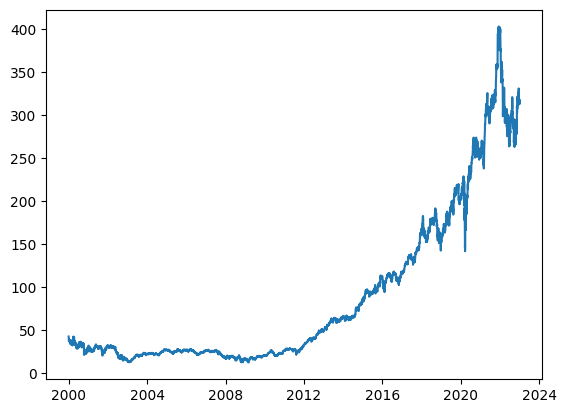

In [35]:
import yfinance
from matplotlib import pyplot as plt
import json
from datetime import *
import pandas as pd

stock_abbr = 'HD'
start, end = '1999-12-31', '2022-12-31'

stock_ticker = yfinance.Ticker(stock_abbr)
stock = stock_ticker.history(start=start, end=end)

plt.plot(stock['Close'])
plt.show()


### Add the low and high prices of the stock from the day before to each row
### Find in what days there was a gap and its type

In [36]:
stock['High_t-1'] = stock.High.shift(1)
stock['Low_t-1'] = stock.Low.shift(1)
stock = stock.tail(-1)

stock['is_gap'] = [stock['High_t-1'][i] < stock['Low'][i] or stock['Low_t-1'][i] > stock['High'][i] for i in range(len(stock))]
stock['is_gap_up'] = [stock['High_t-1'][i] < stock['Low'][i] for i in range(len(stock))]

stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up
Date,,,,,,,,,,,
2000-01-03,42.772145,43.122737,39.772641,40.629642,12030800,0.0,0.0,43.473321,41.915138,False,False
2000-01-04,39.889494,40.084267,38.175493,38.487129,8774500,0.0,0.0,43.122737,39.772641,False,False
2000-01-05,38.487147,39.266239,38.019692,39.266239,6931400,0.0,0.0,40.084267,38.175493,False,False
2000-01-06,38.409239,38.642967,37.396420,37.396420,6603400,0.0,0.0,39.266239,38.019692,False,False
2000-01-07,38.487130,39.577858,37.863856,39.577858,6201600,0.0,0.0,38.642967,37.396420,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,311.891418,316.805842,310.809258,316.438507,2064900,0.0,0.0,314.125245,308.496027,False,False
2022-12-27,316.120806,319.238215,315.227282,317.252594,1610200,0.0,0.0,316.805842,310.809258,False,False
2022-12-28,318.245376,319.119054,313.231695,313.460052,1568200,0.0,0.0,319.238215,315.227282,False,False


### Add how many days took the gap to be filled for each gap
### Add the extremum of the time between the gap and when it was filled and the max return from that gap
### Add the gap size and its ratio

In [37]:
stock['gap_fill_time'] = None
stock['extremum'] = None
stock['max_return'] = None
stock['gap_size'] = None
stock['gap_size_ratio'] = None
gaps_up = []
gaps_down = []

for index, row in stock.iterrows():
    while gaps_up and row['Low'] <= gaps_up[-1][1]:
        stock.loc[gaps_up[-1][0], 'gap_fill_time'] = (index - gaps_up[-1][0]).days
        gaps_up.pop()
    while gaps_down and row['High'] >= gaps_down[-1][1]:
        stock.loc[gaps_down[-1][0], 'gap_fill_time'] = (index - gaps_down[-1][0]).days
        gaps_down.pop()
    if row['is_gap']:
        gaps_up.append([index, row['High_t-1'], row['High']]) if row['is_gap_up'] else gaps_down.append([index, row['Low_t-1'], row['Low']])
        stock.loc[index, 'gap_size'] = row['Low'] - row['High_t-1'] if row['is_gap_up'] else row['Low_t-1'] - row['High']
        stock.loc[index, 'gap_size_ratio'] = (row['Low'] / row['High_t-1']) - 1 if row['is_gap_up'] else 1 - (row['High'] / row['Low_t-1'])
        stock.loc[index, 'extremum'] = row['High'] if row['is_gap_up'] else row['Low']
        stock.loc[index, 'max_return'] = stock.loc[index, 'gap_size_ratio']
    i = len(gaps_up) - 1
    while gaps_up and row['High'] > gaps_up[i][2]:
        gaps_up[i][2] = row['High']
        stock.loc[gaps_up[i][0], 'extremum'] = row['High']
        stock.loc[gaps_up[i][0], 'max_return'] = (row['High'] / stock.loc[gaps_up[i][0], 'High_t-1']) - 1
        i -= 1
    i = len(gaps_down) - 1
    while gaps_down and row['Low'] < gaps_down[i][2]:
        gaps_down[i][2] = row['Low']
        stock.loc[gaps_down[i][0], 'extremum'] = row['Low']
        stock.loc[gaps_down[i][0], 'max_return'] = 1 - (row['Low'] / stock.loc[gaps_down[i][0], 'Low_t-1'])
        i -= 1


stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up,gap_fill_time,extremum,max_return,gap_size,gap_size_ratio
Date,,,,,,,,,,,,,,,,
2000-01-03,42.772145,43.122737,39.772641,40.629642,12030800,0.0,0.0,43.473321,41.915138,False,False,None,None,None,None,None
2000-01-04,39.889494,40.084267,38.175493,38.487129,8774500,0.0,0.0,43.122737,39.772641,False,False,None,None,None,None,None
2000-01-05,38.487147,39.266239,38.019692,39.266239,6931400,0.0,0.0,40.084267,38.175493,False,False,None,None,None,None,None
2000-01-06,38.409239,38.642967,37.396420,37.396420,6603400,0.0,0.0,39.266239,38.019692,False,False,None,None,None,None,None
2000-01-07,38.487130,39.577858,37.863856,39.577858,6201600,0.0,0.0,38.642967,37.396420,False,False,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,311.891418,316.805842,310.809258,316.438507,2064900,0.0,0.0,314.125245,308.496027,False,False,None,None,None,None,None
2022-12-27,316.120806,319.238215,315.227282,317.252594,1610200,0.0,0.0,316.805842,310.809258,False,False,None,None,None,None,None
2022-12-28,318.245376,319.119054,313.231695,313.460052,1568200,0.0,0.0,319.238215,315.227282,False,False,None,None,None,None,None


### display the max, min, and average of the following features: gap fill time, max return, and gap size ratio

In [38]:
gaps_up_analysis = pd.DataFrame(columns=['max', 'min', 'avg'], index=['fill_time', 'max_return', 'gap_size_ratio'])
stock_gaps_up = stock[stock['is_gap_up']]
no_of_gaps_up = len(stock_gaps_up)
gaps_up_analysis.loc['fill_time','max'] = stock_gaps_up.loc[:,'gap_fill_time'].max()
gaps_up_analysis.loc['fill_time','min'] = stock_gaps_up.loc[:,'gap_fill_time'].min()
gaps_up_analysis.loc['fill_time','avg'] = stock_gaps_up.loc[:,'gap_fill_time'].mean()
gaps_up_analysis.loc['max_return','max'] = stock_gaps_up.loc[:,'max_return'].max()
gaps_up_analysis.loc['max_return','min'] = stock_gaps_up.loc[:,'max_return'].min()
gaps_up_analysis.loc['max_return','avg'] = stock_gaps_up.loc[:,'max_return'].mean()
gaps_up_analysis.loc['gap_size_ratio','max'] = stock_gaps_up.loc[:,'gap_size_ratio'].max()
gaps_up_analysis.loc['gap_size_ratio','min'] = stock_gaps_up.loc[:,'gap_size_ratio'].min()
gaps_up_analysis.loc['gap_size_ratio','avg'] = stock_gaps_up.loc[:,'gap_size_ratio'].mean()

print(f'number of gaps up: {no_of_gaps_up}')
print(gaps_up_analysis)

gaps_down_analysis = pd.DataFrame(columns=['max', 'min', 'avg'], index=['fill_time', 'max_return', 'gap_size_ratio'])
stock_gaps = stock[stock['is_gap']]
stock_gaps_down = stock_gaps[stock_gaps['is_gap_up'] == False]
no_of_gaps_down = len(stock_gaps_down)
gaps_down_analysis.loc['fill_time','max'] = stock_gaps_down.loc[:,'gap_fill_time'].max()
gaps_down_analysis.loc['fill_time','min'] = stock_gaps_down.loc[:,'gap_fill_time'].min()
gaps_down_analysis.loc['fill_time','avg'] = stock_gaps_down.loc[:,'gap_fill_time'].mean()
gaps_down_analysis.loc['max_return','max'] = stock_gaps_down.loc[:,'max_return'].max()
gaps_down_analysis.loc['max_return','min'] = stock_gaps_down.loc[:,'max_return'].min()
gaps_down_analysis.loc['max_return','avg'] = stock_gaps_down.loc[:,'max_return'].mean()
gaps_down_analysis.loc['gap_size_ratio','max'] = stock_gaps_down.loc[:,'gap_size_ratio'].max()
gaps_down_analysis.loc['gap_size_ratio','min'] = stock_gaps_down.loc[:,'gap_size_ratio'].min()
gaps_down_analysis.loc['gap_size_ratio','avg'] = stock_gaps_down.loc[:,'gap_size_ratio'].mean()

print(f'\nnumber of gaps down: {no_of_gaps_down}')
print(gaps_down_analysis)

number of gaps up: 237
                      max       min        avg
fill_time            2061         1  77.925234
max_return      14.823984  0.000055   0.597109
gap_size_ratio   0.044674       0.0   0.005838

number of gaps down: 166
                     max  min        avg
fill_time           3479    1  45.463415
max_return      0.608793  0.0   0.068643
gap_size_ratio    0.2235  0.0   0.008669


### Scrape Yahoo Finance and retreive the quarterly earning per share of the stock and its earning announcement timing

In [39]:
!node get_earnings.js {stock_abbr}

f = open(f'{stock_abbr}.json')
earnings = json.load(f)
print(earnings)
f.close()

!rm {stock_abbr}.json

[{'date': '2024-02-19', 'eps': None, 'estimated_eps': None, 'timing': 1}, {'date': '2023-11-14', 'eps': None, 'estimated_eps': None, 'timing': 1}, {'date': '2023-08-15', 'eps': None, 'estimated_eps': None, 'timing': 1}, {'date': '2023-05-16', 'eps': None, 'estimated_eps': 3.86, 'timing': 1}, {'date': '2023-02-21', 'eps': 3.3, 'estimated_eps': 3.28, 'timing': 0}, {'date': '2022-11-15', 'eps': 4.24, 'estimated_eps': 4.12, 'timing': 0}, {'date': '2022-08-16', 'eps': 5.05, 'estimated_eps': 4.94, 'timing': 0}, {'date': '2022-05-17', 'eps': 4.09, 'estimated_eps': 3.68, 'timing': 0}, {'date': '2022-02-22', 'eps': 3.21, 'estimated_eps': 3.18, 'timing': 0}, {'date': '2021-11-16', 'eps': 3.92, 'estimated_eps': 3.4, 'timing': 0}, {'date': '2021-08-17', 'eps': 4.53, 'estimated_eps': 4.44, 'timing': 0}, {'date': '2021-05-18', 'eps': 3.86, 'estimated_eps': 3.08, 'timing': 0}, {'date': '2021-02-23', 'eps': 2.65, 'estimated_eps': 2.62, 'timing': 0}, {'date': '2020-11-17', 'eps': 3.18, 'estimated_eps':

### assign the most relevant quarterly earning per share to each row
### added a feature that indicate if earning was announced at that day
### added a feature that indicated the timing of the earning announcment (-1: not an earning day, 0: announcment before trading period, 1: announcment during trading period, 2: announcment after trading period)

In [40]:
stock['eps'] = None
stock['is_earn_day'] = False
stock['earn_timing'] = -1 # -1: not an earning day, 0: announcment before trading period, 1: announcment during trading period, 2: announcment after trading period

for i in range(len(earnings) - 1):
    if earnings[i+1]['eps']:
        if earnings[i+1]['date'] in stock.index:
            stock.loc[earnings[i+1]['date'], 'is_earn_day'] = True
            stock.loc[earnings[i+1]['date'], 'earn_timing'] = earnings[i+1]['timing']
        stock.loc[earnings[i+1]['date'] : earnings[i]['date'], 'eps'] = earnings[i+1]['eps']
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up,gap_fill_time,extremum,max_return,gap_size,gap_size_ratio,eps,is_earn_day,earn_timing
Date,,,,,,,,,,,,,,,,,,,
2000-01-03,42.772145,43.122737,39.772641,40.629642,12030800,0.0,0.0,43.473321,41.915138,False,False,None,None,None,None,None,0.25,False,-1
2000-01-04,39.889494,40.084267,38.175493,38.487129,8774500,0.0,0.0,43.122737,39.772641,False,False,None,None,None,None,None,0.25,False,-1
2000-01-05,38.487147,39.266239,38.019692,39.266239,6931400,0.0,0.0,40.084267,38.175493,False,False,None,None,None,None,None,0.25,False,-1
2000-01-06,38.409239,38.642967,37.396420,37.396420,6603400,0.0,0.0,39.266239,38.019692,False,False,None,None,None,None,None,0.25,False,-1
2000-01-07,38.487130,39.577858,37.863856,39.577858,6201600,0.0,0.0,38.642967,37.396420,False,False,None,None,None,None,None,0.25,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,311.891418,316.805842,310.809258,316.438507,2064900,0.0,0.0,314.125245,308.496027,False,False,None,None,None,None,None,4.24,False,-1
2022-12-27,316.120806,319.238215,315.227282,317.252594,1610200,0.0,0.0,316.805842,310.809258,False,False,None,None,None,None,None,4.24,False,-1
2022-12-28,318.245376,319.119054,313.231695,313.460052,1568200,0.0,0.0,319.238215,315.227282,False,False,None,None,None,None,None,4.24,False,-1
